In [1]:
% matplotlib inline
import importlib
import os
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import h5py
import matplotlib as mlp
import matplotlib.pyplot as plt

import PyNeuroData as pnd
import PyNeuroAna  as pna
import PyNeuroPlot as pnp
import store_hdf5
import df_ana
import misc_tools

# Load Data from hdf5 file

In [54]:
# set path to data
path_to_hdf5_data = '../../../data/all_data_thor_srv.hdf5'
path_to_fig = '../temp_figs'

In [55]:
# shwo data file stucture
store_hdf5.ShowH5(path_to_hdf5_data)

    (Group)
| 180224    (Group)
| | srv    (Group)
| | | lfp    (Group)
| | | | data    (1920, 915, 16)
| | | | signal_info    (Group)
| | | | trial_info    (Group)
| | | | ts    (915,)
| | | spk    (Group)
| | | | data    (1920, 915, 7)
| | | | signal_info    (Group)
| | | | trial_info    (Group)
| | | | ts    (915,)
| 180317    (Group)
| | srv    (Group)
| | | lfp    (Group)
| | | | data    (2400, 915, 16)
| | | | signal_info    (Group)
| | | | trial_info    (Group)
| | | | ts    (915,)
| | | spk    (Group)
| | | | data    (2400, 915, 11)
| | | | signal_info    (Group)
| | | | trial_info    (Group)
| | | | ts    (915,)
| 180325    (Group)
| | srv    (Group)
| | | lfp    (Group)
| | | | data    (2400, 915, 16)
| | | | signal_info    (Group)
| | | | trial_info    (Group)
| | | | ts    (915,)
| | | spk    (Group)
| | | | data    (2400, 915, 7)
| | | | signal_info    (Group)
| | | | trial_info    (Group)
| | | | ts    (915,)
| 180407    (Group)
| | srv    (Group)
| | | lfp    (Group)
| |

{'180224': {'srv': {'lfp': {'data': None,
    'signal_info': {},
    'trial_info': {},
    'ts': None},
   'spk': {'data': None, 'signal_info': {}, 'trial_info': {}, 'ts': None}}},
 '180317': {'srv': {'lfp': {'data': None,
    'signal_info': {},
    'trial_info': {},
    'ts': None},
   'spk': {'data': None, 'signal_info': {}, 'trial_info': {}, 'ts': None}}},
 '180325': {'srv': {'lfp': {'data': None,
    'signal_info': {},
    'trial_info': {},
    'ts': None},
   'spk': {'data': None, 'signal_info': {}, 'trial_info': {}, 'ts': None}}},
 '180407': {'srv': {'lfp': {'data': None,
    'signal_info': {},
    'trial_info': {},
    'ts': None},
   'spk': {'data': None, 'signal_info': {}, 'trial_info': {}, 'ts': None}}},
 '180411': {'srv': {'lfp': {'data': None,
    'signal_info': {},
    'trial_info': {},
    'ts': None},
   'spk': {'data': None, 'signal_info': {}, 'trial_info': {}, 'ts': None}}},
 '180413': {'srv': {'lfp': {'data': None,
    'signal_info': {},
    'trial_info': {},
    'ts'

In [4]:
# load data from one day
data_neuro_spk = store_hdf5.LoadFromH5(path_to_hdf5_data, ['180624', 'srv_mask', 'spk'])
data_neuro_lfp = store_hdf5.LoadFromH5(path_to_hdf5_data, ['180624', 'srv_mask', 'lfp'])

# Some Plots
## Summary Plot

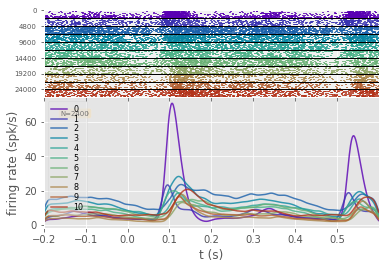

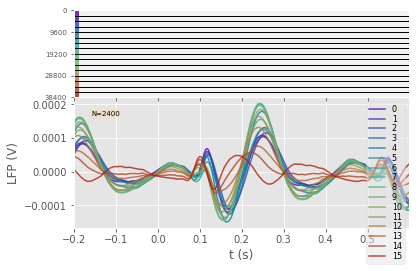

In [5]:
pnp.DataNeuroSummaryPlot(data_neuro_spk, tf_legend=True)
plt.figure()
pnp.DataNeuroSummaryPlot(data_neuro_lfp, tf_legend=True)

(<matplotlib.figure.Figure at 0x7fc49084bc18>,
 {0: <matplotlib.axes._subplots.AxesSubplot at 0x7fc41c170f60>,
  1: <matplotlib.axes._subplots.AxesSubplot at 0x7fc490b7b668>})

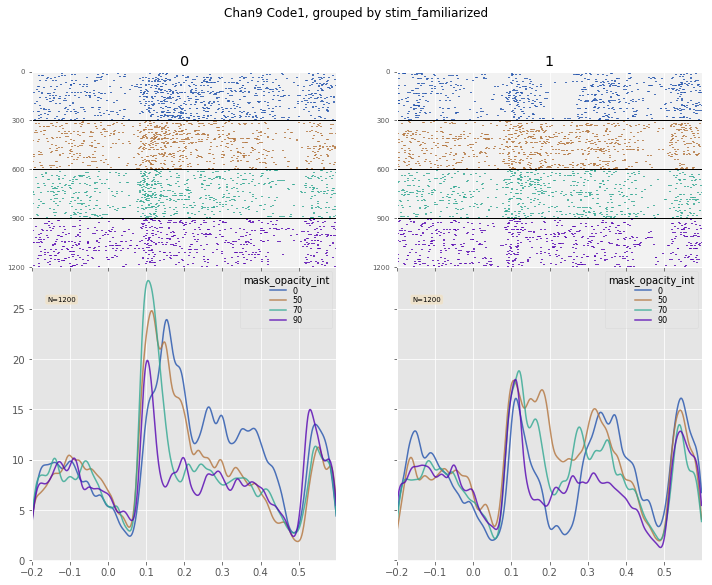

In [6]:
# one channel of spk
pnp.PsthPlotMultiPanel(data_neuro_spk, index_signal=5, sk_std=0.01, 
                       groupby_subplots='stim_familiarized', groupby_panel='mask_opacity_int')

(<matplotlib.figure.Figure at 0x7fc43cdcbcc0>,
 {0: <matplotlib.axes._subplots.AxesSubplot at 0x7fc49ca4d7b8>,
  1: <matplotlib.axes._subplots.AxesSubplot at 0x7fc49ca0ae80>})

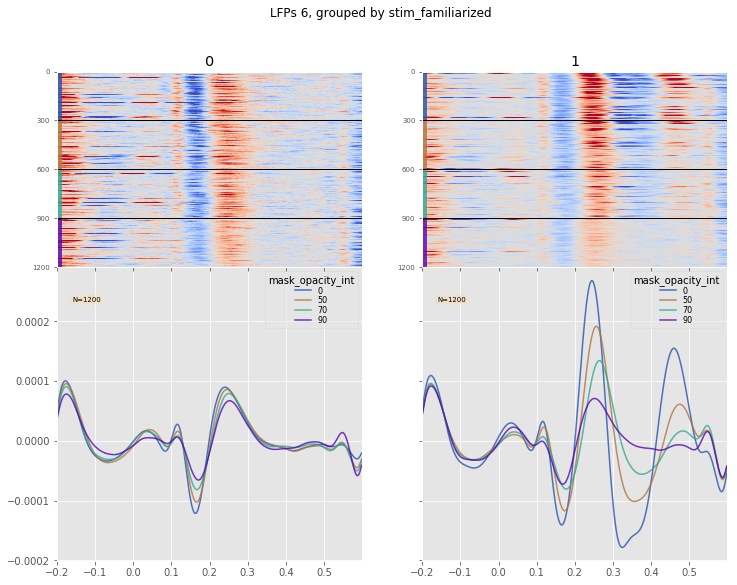

In [7]:
# one channel of lfp
pnp.PsthPlotMultiPanel(data_neuro_lfp, index_signal=5, sk_std=0.01, 
                       groupby_subplots='stim_familiarized', groupby_panel='mask_opacity_int')

## get grouped psth

### get PSTH for every day

In [83]:
tree_struct_hdf5 = store_hdf5.ShowH5(path_to_hdf5_data, yn_print=False)
list_psth_group_mean,list_psth_group_mean_V4,list_psth_group_mean_IT,list_psth_group_mean_IT_old = [],[],[],[]
list_psth_group_std,list_psth_group_std_V4,list_psth_group_std_IT,list_psth_group_std_IT_old = [],[],[],[]
list_signal,list_signal_V4,list_signal_IT,list_signal_IT_old = [],[],[],[]
sk_std = 0.010

for datecode in tree_struct_hdf5.keys():
    print(datecode)
    try:
        # get data
        data_neuro = store_hdf5.LoadFromH5(path_to_hdf5_data, [datecode, 'srv', 'spk'])
        df_ana.GroupDataNeuro(data_neuro, limit=data_neuro['trial_info']['mask_opacity_int']<80,
                  groupby=['stim_familiarized', 'mask_opacity_int'])
        
        # smooth trace over time
        data_neuro['data'] = pna.SmoothTrace(data_neuro['data'], ts=data_neuro['ts'], sk_std=sk_std)
        
        # get mean and std
        psth_group_mean = pna.GroupStat(data_neuro)
        psth_group_std  = pna.GroupStat(data_neuro, statfun='std')
        
        # get signal info
        signal_info = data_neuro['signal_info']
        if signal_info['channel_index'].max()<=16:
            signal_info['channel_index'] = signal_info['channel_index']+64
        signal_info['date'] = datecode
        
        list_psth_group_mean.append(psth_group_mean)
        list_psth_group_std.append(psth_group_std)
        list_signal.append(signal_info)
        list_psth_group_mean_V4.append(psth_group_mean[:,:,(signal_info['channel_index']>5)&(signal_info['channel_index']<=32)])
        list_psth_group_std_V4.append(psth_group_std[:,:,(signal_info['channel_index']>5)&(signal_info['channel_index']<=32)])
        list_signal_V4.append(signal_info[(signal_info['channel_index']>5)&(signal_info['channel_index']<=32)])
        list_psth_group_mean_IT.append(psth_group_mean[:,:,(signal_info['channel_index']>32)&(signal_info['channel_index']<=64)])
        list_psth_group_std_IT.append(psth_group_std[:,:,(signal_info['channel_index']>32)&(signal_info['channel_index']<=64)])
        list_signal_IT.append(signal_info[(signal_info['channel_index']>32)&(signal_info['channel_index']<=64)])
        list_psth_group_mean_IT_old.append(psth_group_mean[:,:,(signal_info['channel_index']>64)])
        list_psth_group_std_IT_old.append(psth_group_std[:,:,(signal_info['channel_index']>64)])
        list_signal_IT_old.append(signal_info[(signal_info['channel_index']>64)])
#         print(psth.shape)
    except:
        print('date {} can not be processed'.format(datecode))
    

180224
180317
180325
180407
180411
180413
180418
180420
180724
180728
180730
180803
180807
180811
180818
180825
180831
180904
180909


### concatenate data together

In [84]:
signal_all = pd.concat(list_signal).reset_index()
signal_V4 = pd.concat(list_signal_V4).reset_index()
ts = data_neuro['ts']
cdtn = data_neuro['cdtn']

def set_signal_id(signal_info):
    signal_info['signal_id'] = signal_info['date'].apply(lambda x: '{}'.format(x)).str.cat(
        [signal_info['channel_index'].apply(lambda x: '{:0>2}'.format(x)),
        signal_info['sort_code'].apply(lambda x: '{:0>1}'.format(x))],
        sep='_'
        )
    return signal_info,
signal_all = set_signal_id(signal_all)
signal_V4 = set_signal_id(signal_V4)


data_group_mean_V4 = np.concatenate(list_psth_group_mean_V4[8:], axis=2)
data_group_std_V4 = np.concatenate(list_psth_group_std_V4[8:], axis=2)
data_group_mean_IT = np.concatenate(list_psth_group_mean_IT[8:], axis=2)
data_group_std_IT = np.concatenate(list_psth_group_std_IT[8:], axis=2)
data_group_mean_IT_old = np.concatenate(list_psth_group_mean_IT_old[:8], axis=2)
data_group_std_IT_old = np.concatenate(list_psth_group_std_IT_old[:8], axis=2)


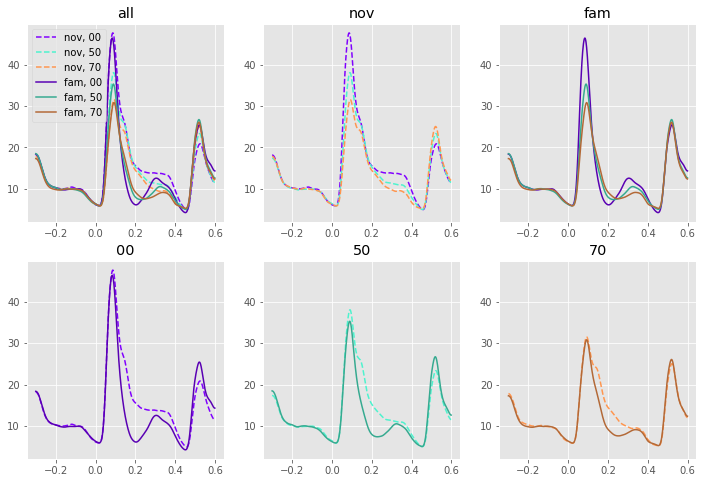

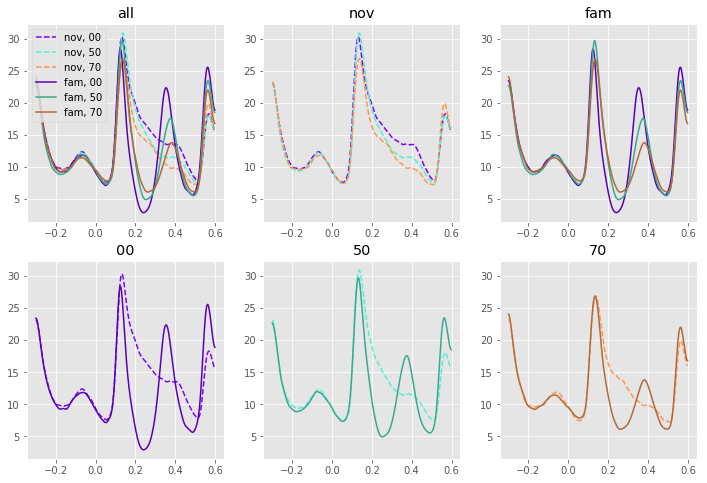

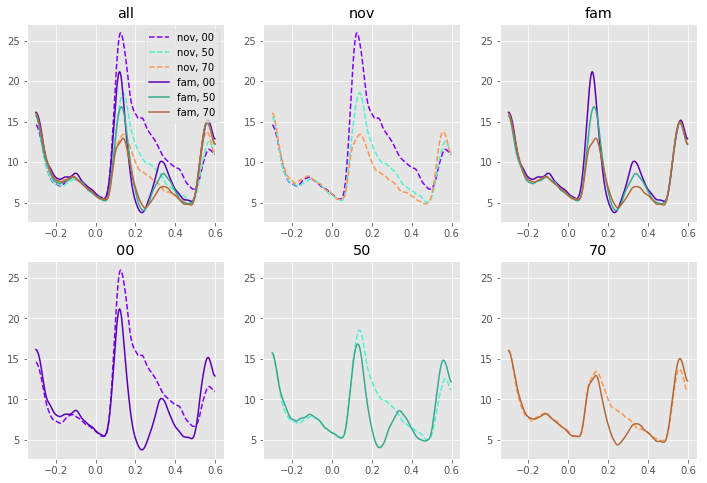

In [85]:

colors = np.vstack([pnp.gen_distinct_colors(3, luminance=1.0, style='continuous', cm='rainbow'), 
                    pnp.gen_distinct_colors(3, luminance=0.7, style='continuous', cm='rainbow')])
linestyles = ['--', '--', '--', '-', '-', '-']
cdtn_name6 = ['nov, 00', 'nov, 50', 'nov, 70', 'fam, 00', 'fam, 50', 'fam, 70']
cdtn_name8 = ['nov, 00', 'nov, 50', 'nov, 70', 'fam, 00', 'fam, 50', 'fam, 70']

plot_highlight = dict()
plot_highlight['all'] = {'trace': [1,1,1,1,1,1], 'compare': [0,0,0,1,0]}
plot_highlight['nov'] = {'trace': [1,1,1,0,0,0], 'compare': [0,0,0,1,0]}
plot_highlight['fam'] = {'trace': [0,0,0,1,1,1], 'compare': [0,0,0,0,1]}
plot_highlight['00']  = {'trace': [1,0,0,1,0,0], 'compare': [1,0,0,0,0]}
plot_highlight['50']  = {'trace': [0,1,0,0,1,0], 'compare': [0,1,0,0,0]}
plot_highlight['70']  = {'trace': [0,0,1,0,0,1], 'compare': [0,0,1,0,0]}

h_fig, h_axes = plt.subplots(2,3, figsize=(12,8))
h_axes = np.ravel(h_axes)
for i, highlight in enumerate(plot_highlight):
    plt.axes(h_axes[i])
    plt.title(highlight)
    for c in range(len(cdtn)):
        plt.plot(ts, data_group_mean_V4[c].mean(axis=1), 
                 color=colors[c], linestyle=linestyles[c],
                 alpha=plot_highlight[highlight]['trace'][c])
    if i==0:
        plt.legend(cdtn_name)
        

h_fig, h_axes = plt.subplots(2,3, figsize=(12,8))
h_axes = np.ravel(h_axes)
for i, highlight in enumerate(plot_highlight):
    plt.axes(h_axes[i])
    plt.title(highlight)
    for c in range(len(cdtn)):
        plt.plot(ts, data_group_mean_IT[c].mean(axis=1), 
                 color=colors[c], linestyle=linestyles[c],
                 alpha=plot_highlight[highlight]['trace'][c])
    if i==0:
        plt.legend(cdtn_name)
        
h_fig, h_axes = plt.subplots(2,3, figsize=(12,8))
h_axes = np.ravel(h_axes)
for i, highlight in enumerate(plot_highlight):
    plt.axes(h_axes[i])
    plt.title(highlight)
    for c in range(len(cdtn)):
        plt.plot(ts, data_group_mean_IT_old[c].mean(axis=1), 
                 color=colors[c], linestyle=linestyles[c],
                 alpha=plot_highlight[highlight]['trace'][c])
    if i==0:
        plt.legend(cdtn_name)

In [82]:
cdtn


[(0, 0), (0, 50), (0, 70), (0, 90), (1, 0), (1, 50), (1, 70), (1, 90)]

## Save figure for every neurons

In [110]:
colors = np.vstack([pnp.gen_distinct_colors(3, luminance=1.0, style='continuous', cm='rainbow'), 
                    pnp.gen_distinct_colors(3, luminance=0.7, style='continuous', cm='rainbow')])
linestyles = ['--', '--', '--', '-', '-', '-']
cdtn_name = ['nov, 00', 'nov, 50', 'nov, 70', 'fam, 00', 'fam, 50', 'fam, 70']

plot_highlight = dict()
plot_highlight['all'] = {'trace': [1,1,1,1,1,1], 'compare': [0,0,0,1,0]}
plot_highlight['nov'] = {'trace': [1,1,1,0,0,0], 'compare': [0,0,0,1,0]}
plot_highlight['fam'] = {'trace': [0,0,0,1,1,1], 'compare': [0,0,0,0,1]}
plot_highlight['00']  = {'trace': [1,0,0,1,0,0], 'compare': [1,0,0,0,0]}
plot_highlight['50']  = {'trace': [0,1,0,0,1,0], 'compare': [0,1,0,0,0]}
plot_highlight['70']  = {'trace': [0,0,1,0,0,1], 'compare': [0,0,1,0,0]}

for i_signal, signal_id_cur in enumerate(signal_all['signal_id']):
    h_fig, h_axes = plt.subplots(2,3, figsize=(12,8))
    h_axes = np.ravel(h_axes)
    plt.suptitle(signal_id_cur)
    for i, highlight in enumerate(plot_highlight):
        plt.axes(h_axes[i])
        plt.title(highlight)
        for c in range(len(cdtn)):
            plt.plot(ts, data_group_mean[c, :, i_signal], 
                     color=colors[c], linestyle=linestyles[c],
                     alpha=plot_highlight[highlight]['trace'][c])
        if i==0:
            plt.legend(cdtn_name)
    plt.savefig(os.path.join(path_to_fig, 'psth_svr_mask_spk_thor', 'psth_{}.png'.format(signal_id_cur)))
    plt.savefig(os.path.join(path_to_fig, 'psth_svr_mask_spk_thor', 'psth_{}.pdf'.format(signal_id_cur)))
    plt.close('all')

In [39]:
tree_struct_hdf5 = store_hdf5.ShowH5(path_to_hdf5_data, yn_print=False)
list_psth_group_mean,list_psth_group_mean_V4,list_psth_group_mean_IT = [],[],[]
list_psth_group_std,list_psth_group_std_V4,list_psth_group_std_IT = [],[],[]
list_signal,list_signal_V4,list_signal_IT = [],[],[]
sk_std = 0.010

for datecode in tree_struct_hdf5.keys():
    print(datecode)
    try:
        # get data
        data_neuro = store_hdf5.LoadFromH5(path_to_hdf5_data, [datecode, 'srv', 'lfp'])
        df_ana.GroupDataNeuro(data_neuro, limit=data_neuro['trial_info']['mask_opacity_int']<80,
                  groupby=['stim_familiarized', 'mask_opacity_int'])
        
        # smooth trace over time
        data_neuro['data'] = pna.SmoothTrace(data_neuro['data'], ts=data_neuro['ts'], sk_std=sk_std)
        
        # get mean and std
        psth_group_mean = pna.GroupStat(data_neuro)
        psth_group_std  = pna.GroupStat(data_neuro, statfun='std')
        
        # get signal info
        signal_info = data_neuro['signal_info']
        signal_info['date'] = datecode
        
        list_psth_group_mean.append(psth_group_mean)
        list_psth_group_std.append(psth_group_std)
        list_signal.append(signal_info)
        list_psth_group_mean_V4.append(psth_group_mean[:,:,(signal_info['channel_index']>5)&(signal_info['channel_index']<=32)])
        list_psth_group_std_V4.append(psth_group_std[:,:,(signal_info['channel_index']>5)&(signal_info['channel_index']<=32)])
        list_signal_V4.append(signal_info[(signal_info['channel_index']>5)&(signal_info['channel_index']<=32)])
        list_psth_group_mean_IT.append(psth_group_mean[:,:,signal_info['channel_index']>32])
        list_psth_group_std_IT.append(psth_group_std[:,:,signal_info['channel_index']>32])
        list_signal_IT.append(signal_info[signal_info['channel_index']>32])
#         print(psth.shape)
    except:
        print('date {} can not be processed'.format(datacode))
    

180724
180728
180730
180803
180807
180811
180818
180825
180831
180904
180909


In [40]:
signal_all = pd.concat(list_signal).reset_index()
signal_V4 = pd.concat(list_signal_V4).reset_index()
ts = data_neuro['ts']
cdtn = data_neuro['cdtn']

def set_signal_id(signal_info):
    signal_info['signal_id'] = signal_info['date'].apply(lambda x: '{}'.format(x)).str.cat(
        [signal_info['channel_index'].apply(lambda x: '{:0>2}'.format(x)),
        signal_info['sort_code'].apply(lambda x: '{:0>1}'.format(x))],
        sep='_'
        )
    return signal_info,
signal_all = set_signal_id(signal_all)
signal_V4 = set_signal_id(signal_V4)

data_group_mean = np.concatenate(list_psth_group_mean, axis=2)
data_group_std = np.concatenate(list_psth_group_std, axis=2)
data_group_mean_V4 = np.concatenate(list_psth_group_mean_V4, axis=2)
data_group_std_V4 = np.concatenate(list_psth_group_std_V4, axis=2)
data_group_mean_IT = np.concatenate(list_psth_group_mean_IT, axis=2)
data_group_std_IT = np.concatenate(list_psth_group_std_IT, axis=2)


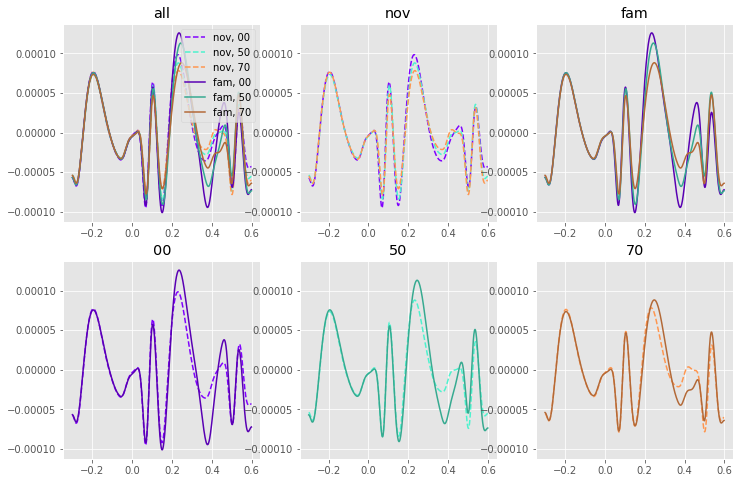

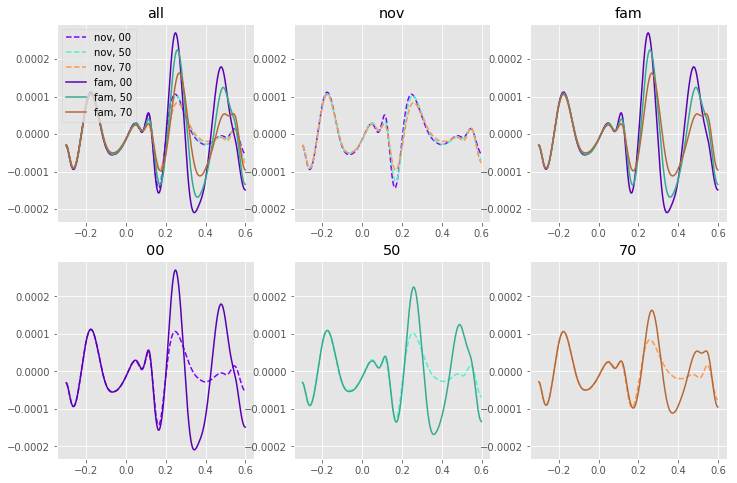

In [41]:

colors = np.vstack([pnp.gen_distinct_colors(3, luminance=1.0, style='continuous', cm='rainbow'), 
                    pnp.gen_distinct_colors(3, luminance=0.7, style='continuous', cm='rainbow')])
linestyles = ['--', '--', '--', '-', '-', '-']
cdtn_name = ['nov, 00', 'nov, 50', 'nov, 70', 'fam, 00', 'fam, 50', 'fam, 70']

plot_highlight = dict()
plot_highlight['all'] = {'trace': [1,1,1,1,1,1], 'compare': [0,0,0,1,0]}
plot_highlight['nov'] = {'trace': [1,1,1,0,0,0], 'compare': [0,0,0,1,0]}
plot_highlight['fam'] = {'trace': [0,0,0,1,1,1], 'compare': [0,0,0,0,1]}
plot_highlight['00']  = {'trace': [1,0,0,1,0,0], 'compare': [1,0,0,0,0]}
plot_highlight['50']  = {'trace': [0,1,0,0,1,0], 'compare': [0,1,0,0,0]}
plot_highlight['70']  = {'trace': [0,0,1,0,0,1], 'compare': [0,0,1,0,0]}

h_fig, h_axes = plt.subplots(2,3, figsize=(12,8))
h_axes = np.ravel(h_axes)
for i, highlight in enumerate(plot_highlight):
    plt.axes(h_axes[i])
    plt.title(highlight)
    for c in range(len(cdtn)):
        plt.plot(ts, data_group_mean_V4[c].mean(axis=1), 
                 color=colors[c], linestyle=linestyles[c],
                 alpha=plot_highlight[highlight]['trace'][c])
    if i==0:
        plt.legend(cdtn_name)
        

h_fig, h_axes = plt.subplots(2,3, figsize=(12,8))
h_axes = np.ravel(h_axes)
for i, highlight in enumerate(plot_highlight):
    plt.axes(h_axes[i])
    plt.title(highlight)
    for c in range(len(cdtn)):
        plt.plot(ts, data_group_mean_IT[c].mean(axis=1), 
                 color=colors[c], linestyle=linestyles[c],
                 alpha=plot_highlight[highlight]['trace'][c])
    if i==0:
        plt.legend(cdtn_name)